In [1]:
import json
import os
import warnings
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
from stamox.sample import bootstrap

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False
CHECK_THERMALISED: bool = True

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = "experiments/measure_3D/N16_wolff/experiment.ipynb"
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "tpu"
ALGORITHM = "wolff"
DIMENSIONS = 3
SPIN = 0.5
TOTAL_SAMPLES = 512
N_TEMPS = 16
N_SAMPLES_VECTORISE = 32
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 25
TEMP_MIN = 2.25
TEMP_MAX = 2.26
CHECK_THERMALISED = True
DO_AUTOCORRELATION = False
DO_MEASURE = True
MEASURE_EQUILIBRIUM_NUM = 1
MEASURE_EQUILIBRIUM_STEPS = 1000
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP = 10
PLOT_STATES = False
SIZE = 16


In [5]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "tpu"
    ALGORITHM = "wolff"
    DIMENSIONS = 3
    SPIN = 0.5
    TOTAL_SAMPLES = 64
    N_TEMPS = 32
    N_SAMPLES_VECTORISE = 2
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 50
    TEMP_MIN = 2.2
    TEMP_MAX = 2.4
    DO_AUTOCORRELATION = False
    DO_MEASURE = True
    SIZE = 32

In [6]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "CHECK_THERMALISED",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

Initialized persistent compilation cache at /tmp/xla_comp_cache


SAVE_PATH=PosixPath('/home/jeppe/JaxIsingModel/experiments/measure_3D/N16_wolff')


In [7]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF | AlgorithmChoice.SWENDSEN_WANG:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 16
c.n_temps=16
N_TEMPS_X=8
N_TEMPS_Y=2
N_SAMPLES_PER_TEMP=32
--c.n_samples_vectorise=32
--N_SAMPLES_LOOP=1
Vectorised count: 512
Total sweeps: 1_280_000


In [8]:
# Single state
if not PAPERMILL:
    model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
    state = State.new_uniform_random(
        rng_key=k.new,
        dimensions=c.dimensions,
        size=c.size,
        beta=1.0,
        model=model,
        algorithm=algorithm,
        id_=0,
    )

    initial_state = state

    state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
    measured = state.measure()

    state.calculate_energy()
    state.calculate_magnetisation_density()

# Thermalisation

In [9]:
@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 10

thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 8, 2, 32)


/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 7.31124472618103 sec.


  0%|                                                                                                                                   | 0/800 [00:00<?, ?it/s]

  2%|██▋                                                                                                                       | 18/800 [00:03<02:43,  4.77it/s]

 11%|█████████████▍                                                                                                            | 88/800 [00:03<00:23, 30.13it/s]

 17%|████████████████████▊                                                                                                    | 138/800 [00:07<00:35, 18.85it/s]

 22%|██████████████████████████▉                                                                                              | 178/800 [00:11<00:41, 14.84it/s]

 30%|███████████████████████████████████▉                                                                                     | 238/800 [00:11<00:22, 25.37it/s]

 35%|██████████████████████████████████████████                                                                               | 278/800 [00:15<00:28, 18.08it/s]

 41%|█████████████████████████████████████████████████▌                                                                       | 328/800 [00:15<00:17, 26.73it/s]

 45%|██████████████████████████████████████████████████████▏                                                                  | 358/800 [00:19<00:25, 17.54it/s]

 51%|█████████████████████████████████████████████████████████████▋                                                           | 408/800 [00:19<00:14, 26.35it/s]

 55%|██████████████████████████████████████████████████████████████████▏                                                      | 438/800 [00:23<00:20, 17.33it/s]

 60%|████████████████████████████████████████████████████████████████████████▎                                                | 478/800 [00:23<00:13, 24.38it/s]

 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 508/800 [00:26<00:17, 16.44it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▊                                         | 528/800 [00:26<00:13, 19.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████▍                                 | 578/800 [00:30<00:13, 16.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                              | 598/800 [00:30<00:10, 20.05it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████                       | 648/800 [00:30<00:04, 32.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 678/800 [00:34<00:06, 18.28it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 728/800 [00:34<00:02, 28.67it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 755/800 [00:34<00:01, 34.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:35<00:00, 49.99it/s]

Ran thermalisation program in: 38.60736131668091 sec.


In [10]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [11]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 12.0439532809795 flips/μs


In [12]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:50<00:00, 49.99it/s]

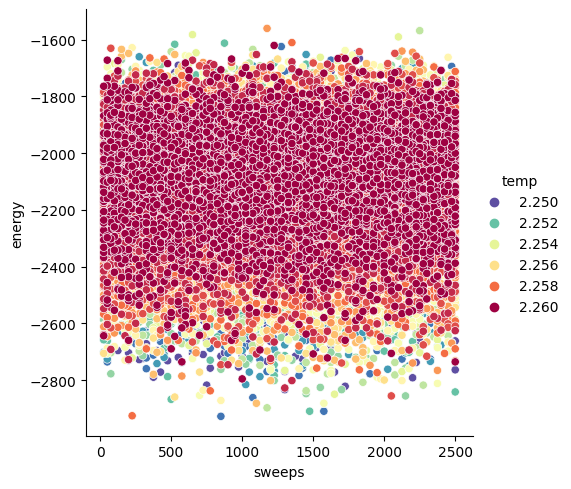

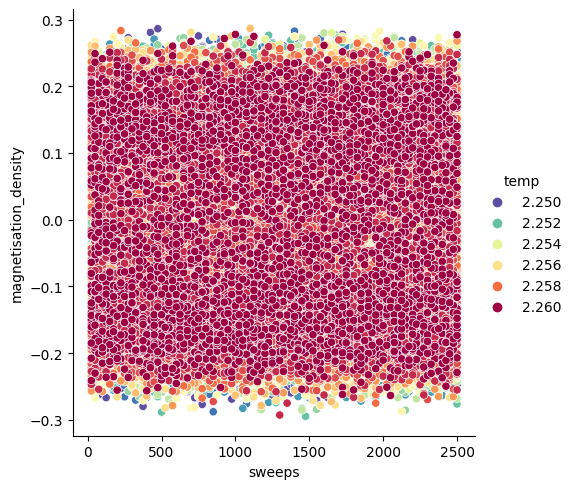

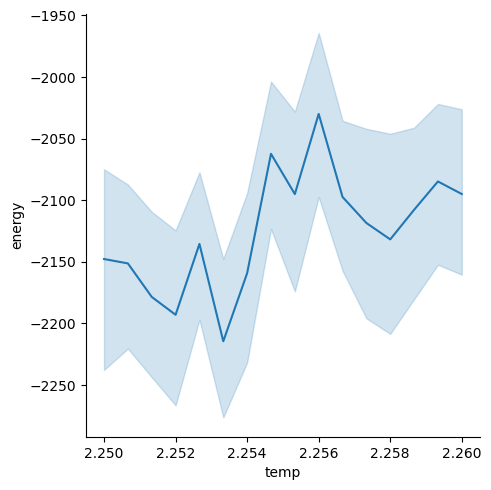

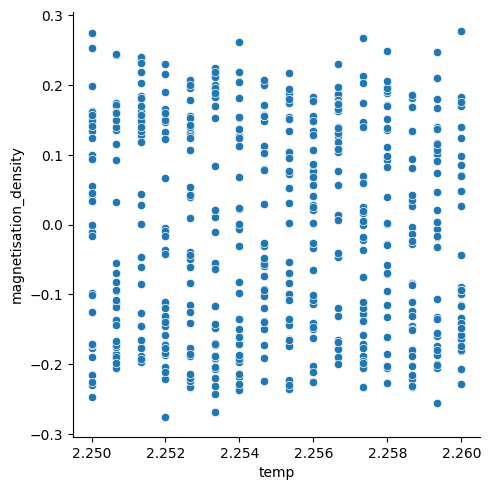

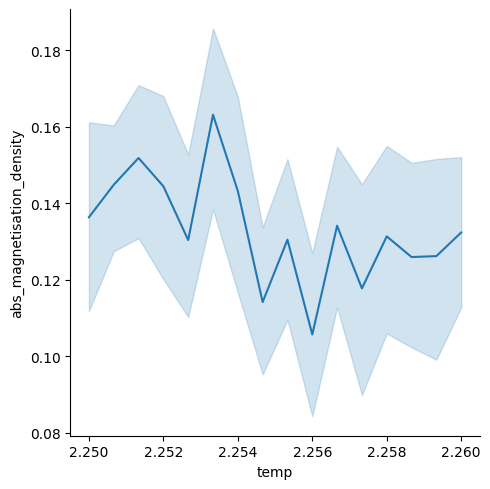

In [13]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [14]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [15]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

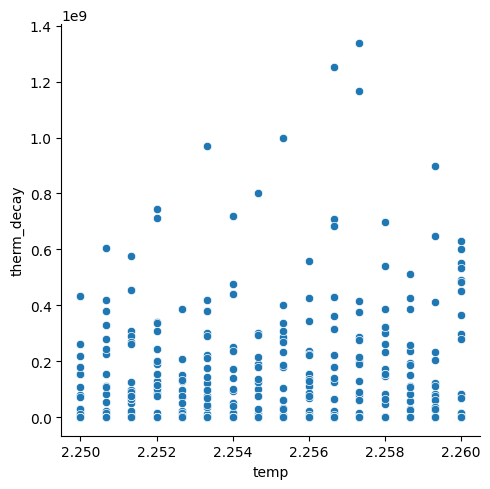

In [16]:
if c.check_thermalised:
    # Fit saturating decay times to quantifiably understand whether we have fully thermalised
    def fit_thermalisation(group):
        x = group["sweeps"]
        y = group["energy"]

        amplitude = np.max(y) - np.min(y)
        decay = np.max(x)
        offset = y.iloc[-1]

        params = SaturatingExponential.make_params()
        params["amplitude"].set(amplitude)
        params["decay"].set(decay, min=0, max=np.inf)
        params["c"].set(offset)

        fit = SaturatingExponential.fit(y, params, x=x)

        assert np.ptp(group["temp"]) == 0.0

        return pd.Series(
            {
                "temp": group["temp"].iloc[0],
                "therm_amplitude": fit.params["amplitude"].value,
                "therm_amplitude_sd": fit.params["amplitude"].stderr,
                "therm_decay": fit.params["decay"].value,
                "therm_decay_sd": fit.params["decay"].stderr,
                "therm_offset": fit.params["c"].value,
                "therm_offset_sd": fit.params["c"].stderr,
            }
        )

    evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
        fit_thermalisation
    )
    fig_evolve_therm_fit = sns.relplot(
        data=evolve_meas_fit_df,
        x="temp",
        y="therm_decay",
    )
    fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

    def _has_thermalised():
        high_temp_df = evolve_meas_fit_df[
            evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
        ]
        therm_check_df = high_temp_df[
            high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
        ]

        # We have no data to check probably because system is very very thermalised
        # and thus has no data to fit to exponential
        if not len(therm_check_df):
            return True

        longest_decay = therm_check_df["therm_decay"].max()
        print(longest_decay)
        if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
            return True

        return False

    has_thermalised = _has_thermalised()

    if not has_thermalised:
        raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [17]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

In [18]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

In [19]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [20]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        100,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function measure_equilibrium includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|                                                                                                                                  | 0/8000 [00:00<?, ?it/s]

  0%|▎                                                                                                                        | 18/8000 [00:01<11:17, 11.78it/s]

  1%|█▍                                                                                                                       | 98/8000 [00:03<03:42, 35.57it/s]

  2%|██▌                                                                                                                     | 168/8000 [00:03<01:52, 69.53it/s]

  2%|██▉                                                                                                                     | 198/8000 [00:04<02:55, 44.34it/s]

  3%|███▊                                                                                                                    | 258/8000 [00:06<03:03, 42.16it/s]

  4%|█████                                                                                                                   | 338/8000 [00:07<02:45, 46.35it/s]

  5%|█████▌                                                                                                                  | 368/8000 [00:07<02:18, 55.15it/s]

  5%|██████▎                                                                                                                 | 418/8000 [00:09<02:43, 46.41it/s]

  6%|███████                                                                                                                 | 468/8000 [00:09<01:57, 64.17it/s]

  6%|███████▍                                                                                                                | 498/8000 [00:10<02:47, 44.70it/s]

  7%|████████                                                                                                                | 538/8000 [00:10<02:05, 59.67it/s]

  7%|████████▋                                                                                                               | 578/8000 [00:12<02:45, 44.77it/s]

  8%|█████████▍                                                                                                              | 628/8000 [00:12<01:54, 64.18it/s]

  8%|█████████▊                                                                                                              | 658/8000 [00:13<02:46, 43.97it/s]

  9%|██████████▌                                                                                                             | 708/8000 [00:14<01:55, 63.35it/s]

  9%|███████████                                                                                                             | 738/8000 [00:15<02:45, 44.00it/s]

  9%|███████████▎                                                                                                            | 758/8000 [00:15<02:21, 51.16it/s]

 10%|████████████                                                                                                            | 808/8000 [00:15<01:35, 75.65it/s]

 10%|████████████▌                                                                                                           | 838/8000 [00:17<02:34, 46.48it/s]

 11%|█████████████                                                                                                           | 868/8000 [00:17<01:59, 59.73it/s]

 11%|█████████████▍                                                                                                          | 898/8000 [00:18<02:52, 41.17it/s]

 11%|█████████████▊                                                                                                          | 918/8000 [00:18<02:25, 48.77it/s]

 12%|██████████████▏                                                                                                         | 948/8000 [00:18<01:48, 65.22it/s]

 12%|██████████████▋                                                                                                         | 978/8000 [00:20<02:48, 41.67it/s]

 12%|██████████████▉                                                                                                         | 998/8000 [00:20<02:20, 49.67it/s]

 13%|███████████████▎                                                                                                       | 1028/8000 [00:20<01:43, 67.54it/s]

 13%|███████████████▋                                                                                                       | 1058/8000 [00:21<02:45, 41.86it/s]

 13%|████████████████                                                                                                       | 1078/8000 [00:21<02:17, 50.23it/s]

 14%|████████████████▍                                                                                                      | 1108/8000 [00:21<01:41, 68.01it/s]

 14%|████████████████▉                                                                                                      | 1138/8000 [00:23<02:42, 42.24it/s]

 14%|█████████████████▏                                                                                                     | 1158/8000 [00:23<02:14, 50.96it/s]

 15%|█████████████████▋                                                                                                     | 1188/8000 [00:23<01:40, 67.69it/s]

 15%|██████████████████                                                                                                     | 1218/8000 [00:24<02:38, 42.66it/s]

 15%|██████████████████▍                                                                                                    | 1238/8000 [00:24<02:13, 50.76it/s]

 16%|██████████████████▊                                                                                                    | 1268/8000 [00:24<01:39, 67.72it/s]

 16%|███████████████████▎                                                                                                   | 1298/8000 [00:26<02:36, 42.74it/s]

 16%|███████████████████▌                                                                                                   | 1318/8000 [00:26<02:11, 50.69it/s]

 17%|████████████████████                                                                                                   | 1348/8000 [00:26<01:37, 68.04it/s]

 17%|████████████████████▎                                                                                                  | 1368/8000 [00:26<01:22, 80.37it/s]

 17%|████████████████████▋                                                                                                  | 1388/8000 [00:27<02:46, 39.63it/s]

 18%|████████████████████▉                                                                                                  | 1408/8000 [00:27<02:10, 50.47it/s]

 18%|█████████████████████▏                                                                                                 | 1428/8000 [00:28<01:43, 63.37it/s]

 18%|█████████████████████▌                                                                                                 | 1448/8000 [00:28<01:26, 76.11it/s]

 18%|█████████████████████▊                                                                                                 | 1468/8000 [00:29<02:54, 37.36it/s]

 19%|██████████████████████▏                                                                                                | 1488/8000 [00:29<02:14, 48.27it/s]

 19%|██████████████████████▌                                                                                                | 1518/8000 [00:29<01:36, 66.87it/s]

 19%|██████████████████████▉                                                                                                | 1538/8000 [00:30<02:46, 38.89it/s]

 19%|███████████████████████▏                                                                                               | 1558/8000 [00:31<02:21, 45.52it/s]

 20%|███████████████████████▌                                                                                               | 1588/8000 [00:31<01:38, 65.14it/s]

 20%|███████████████████████▉                                                                                               | 1608/8000 [00:31<01:24, 75.63it/s]

 20%|████████████████████████▏                                                                                              | 1628/8000 [00:32<02:44, 38.82it/s]

 21%|████████████████████████▋                                                                                              | 1658/8000 [00:32<01:52, 56.51it/s]

 21%|████████████████████████▉                                                                                              | 1678/8000 [00:32<01:42, 61.87it/s]

 21%|█████████████████████████▎                                                                                             | 1698/8000 [00:33<02:40, 39.30it/s]

 21%|█████████████████████████▍                                                                                             | 1708/8000 [00:33<02:30, 41.75it/s]

 21%|█████████████████████████▌                                                                                             | 1718/8000 [00:34<02:14, 46.56it/s]

 22%|██████████████████████████                                                                                             | 1748/8000 [00:34<01:26, 72.39it/s]

 22%|██████████████████████████▎                                                                                            | 1768/8000 [00:34<01:15, 82.45it/s]

 22%|██████████████████████████▌                                                                                            | 1788/8000 [00:35<02:41, 38.50it/s]

 23%|██████████████████████████▉                                                                                            | 1808/8000 [00:35<02:03, 50.24it/s]

 23%|███████████████████████████▏                                                                                           | 1828/8000 [00:35<01:35, 64.67it/s]

 23%|███████████████████████████▍                                                                                           | 1848/8000 [00:35<01:22, 74.20it/s]

 23%|███████████████████████████▊                                                                                           | 1868/8000 [00:37<02:44, 37.29it/s]

 24%|████████████████████████████                                                                                           | 1888/8000 [00:37<02:04, 49.10it/s]

 24%|████████████████████████████▍                                                                                          | 1908/8000 [00:37<01:36, 62.97it/s]

 24%|████████████████████████████▋                                                                                          | 1928/8000 [00:37<01:21, 74.10it/s]

 24%|████████████████████████████▉                                                                                          | 1948/8000 [00:38<02:44, 36.86it/s]

 25%|█████████████████████████████▍                                                                                         | 1978/8000 [00:38<01:52, 53.31it/s]

 25%|█████████████████████████████▋                                                                                         | 1998/8000 [00:39<01:37, 61.41it/s]

 25%|██████████████████████████████                                                                                         | 2018/8000 [00:39<02:29, 39.98it/s]

 25%|██████████████████████████████▏                                                                                        | 2028/8000 [00:40<02:27, 40.61it/s]

 26%|██████████████████████████████▌                                                                                        | 2058/8000 [00:40<01:42, 58.16it/s]

 26%|██████████████████████████████▉                                                                                        | 2078/8000 [00:40<01:25, 69.36it/s]

 26%|███████████████████████████████▏                                                                                       | 2098/8000 [00:41<02:24, 40.92it/s]

 26%|███████████████████████████████▎                                                                                       | 2108/8000 [00:41<02:21, 41.66it/s]

 27%|███████████████████████████████▊                                                                                       | 2138/8000 [00:41<01:35, 61.08it/s]

 27%|████████████████████████████████                                                                                       | 2158/8000 [00:42<01:20, 72.30it/s]

 27%|████████████████████████████████▍                                                                                      | 2178/8000 [00:43<02:19, 41.70it/s]

 27%|████████████████████████████████▌                                                                                      | 2188/8000 [00:43<02:21, 40.94it/s]

 28%|████████████████████████████████▉                                                                                      | 2218/8000 [00:43<01:35, 60.46it/s]

 28%|█████████████████████████████████▏                                                                                     | 2228/8000 [00:43<01:29, 64.49it/s]

 28%|█████████████████████████████████▍                                                                                     | 2248/8000 [00:43<01:11, 80.59it/s]

 28%|█████████████████████████████████▋                                                                                     | 2268/8000 [00:44<02:32, 37.59it/s]

 29%|██████████████████████████████████▏                                                                                    | 2298/8000 [00:45<01:42, 55.60it/s]

 29%|██████████████████████████████████▍                                                                                    | 2318/8000 [00:45<01:28, 64.53it/s]

 29%|██████████████████████████████████▊                                                                                    | 2338/8000 [00:46<02:18, 40.81it/s]

 29%|██████████████████████████████████▉                                                                                    | 2348/8000 [00:46<02:20, 40.37it/s]

 30%|███████████████████████████████████▎                                                                                   | 2378/8000 [00:46<01:34, 59.67it/s]

 30%|███████████████████████████████████▋                                                                                   | 2398/8000 [00:46<01:21, 68.64it/s]

 30%|███████████████████████████████████▉                                                                                   | 2418/8000 [00:47<02:12, 42.22it/s]

 30%|████████████████████████████████████                                                                                   | 2428/8000 [00:47<02:14, 41.49it/s]

 31%|████████████████████████████████████▌                                                                                  | 2458/8000 [00:48<01:31, 60.74it/s]

 31%|████████████████████████████████████▋                                                                                  | 2468/8000 [00:48<01:30, 61.07it/s]

 31%|█████████████████████████████████████                                                                                  | 2488/8000 [00:48<01:16, 72.13it/s]

 31%|█████████████████████████████████████▏                                                                                 | 2498/8000 [00:49<02:19, 39.40it/s]

 31%|█████████████████████████████████████▎                                                                                 | 2508/8000 [00:49<02:20, 39.09it/s]

 32%|█████████████████████████████████████▌                                                                                 | 2528/8000 [00:49<01:39, 54.88it/s]

 32%|█████████████████████████████████████▉                                                                                 | 2548/8000 [00:49<01:25, 63.64it/s]

 32%|██████████████████████████████████████▏                                                                                | 2568/8000 [00:50<01:14, 72.64it/s]

 32%|██████████████████████████████████████▎                                                                                | 2578/8000 [00:50<02:18, 39.24it/s]

 32%|██████████████████████████████████████▍                                                                                | 2588/8000 [00:51<02:18, 39.06it/s]

 33%|██████████████████████████████████████▊                                                                                | 2608/8000 [00:51<01:36, 55.81it/s]

 33%|███████████████████████████████████████                                                                                | 2628/8000 [00:51<01:23, 64.46it/s]

 33%|███████████████████████████████████████▍                                                                               | 2648/8000 [00:51<01:13, 72.67it/s]

 33%|███████████████████████████████████████▌                                                                               | 2658/8000 [00:52<02:15, 39.39it/s]

 33%|███████████████████████████████████████▋                                                                               | 2668/8000 [00:52<02:16, 38.99it/s]

 34%|███████████████████████████████████████▉                                                                               | 2688/8000 [00:52<01:35, 55.77it/s]

 34%|████████████████████████████████████████▎                                                                              | 2708/8000 [00:52<01:23, 63.73it/s]

 34%|████████████████████████████████████████▌                                                                              | 2728/8000 [00:53<01:11, 73.27it/s]

 34%|████████████████████████████████████████▋                                                                              | 2738/8000 [00:53<02:10, 40.31it/s]

 34%|████████████████████████████████████████▉                                                                              | 2748/8000 [00:54<02:14, 38.99it/s]

 35%|█████████████████████████████████████████▏                                                                             | 2768/8000 [00:54<01:36, 54.12it/s]

 35%|█████████████████████████████████████████▍                                                                             | 2788/8000 [00:54<01:23, 62.22it/s]

 35%|█████████████████████████████████████████▊                                                                             | 2808/8000 [00:54<01:10, 73.50it/s]

 35%|█████████████████████████████████████████▉                                                                             | 2818/8000 [00:55<02:07, 40.68it/s]

 35%|██████████████████████████████████████████                                                                             | 2828/8000 [00:55<02:13, 38.76it/s]

 36%|██████████████████████████████████████████▎                                                                            | 2848/8000 [00:55<01:32, 55.92it/s]

 36%|██████████████████████████████████████████▋                                                                            | 2868/8000 [00:56<01:24, 60.41it/s]

 36%|██████████████████████████████████████████▉                                                                            | 2888/8000 [00:56<01:08, 74.41it/s]

 36%|███████████████████████████████████████████▎                                                                           | 2908/8000 [00:57<02:12, 38.52it/s]

 37%|███████████████████████████████████████████▊                                                                           | 2948/8000 [00:57<01:29, 56.33it/s]

 37%|████████████████████████████████████████████▏                                                                          | 2968/8000 [00:57<01:16, 65.72it/s]

 37%|████████████████████████████████████████████▍                                                                          | 2988/8000 [00:58<02:04, 40.27it/s]

 38%|████████████████████████████████████████████▉                                                                          | 3018/8000 [00:58<01:26, 57.82it/s]

 38%|█████████████████████████████████████████████▏                                                                         | 3038/8000 [00:59<01:23, 59.37it/s]

 38%|█████████████████████████████████████████████▍                                                                         | 3058/8000 [00:59<01:48, 45.68it/s]

 38%|█████████████████████████████████████████████▋                                                                         | 3068/8000 [01:00<02:01, 40.60it/s]

 39%|██████████████████████████████████████████████                                                                         | 3098/8000 [01:00<01:22, 59.28it/s]

 39%|██████████████████████████████████████████████▏                                                                        | 3108/8000 [01:00<01:26, 56.47it/s]

 39%|██████████████████████████████████████████████▍                                                                        | 3118/8000 [01:00<01:19, 61.09it/s]

 39%|██████████████████████████████████████████████▋                                                                        | 3138/8000 [01:01<01:46, 45.75it/s]

 39%|██████████████████████████████████████████████▊                                                                        | 3148/8000 [01:01<02:06, 38.39it/s]

 40%|███████████████████████████████████████████████▎                                                                       | 3178/8000 [01:01<01:17, 61.99it/s]

 40%|███████████████████████████████████████████████▌                                                                       | 3198/8000 [01:02<01:19, 60.05it/s]

 40%|███████████████████████████████████████████████▊                                                                       | 3218/8000 [01:02<01:39, 48.13it/s]

 40%|████████████████████████████████████████████████                                                                       | 3228/8000 [01:03<01:59, 40.05it/s]

 41%|████████████████████████████████████████████████▍                                                                      | 3258/8000 [01:03<01:16, 62.37it/s]

 41%|████████████████████████████████████████████████▊                                                                      | 3278/8000 [01:03<01:20, 58.72it/s]

 41%|█████████████████████████████████████████████████                                                                      | 3298/8000 [01:04<01:36, 48.73it/s]

 41%|█████████████████████████████████████████████████▏                                                                     | 3308/8000 [01:04<01:57, 39.99it/s]

 42%|█████████████████████████████████████████████████▋                                                                     | 3338/8000 [01:05<01:14, 62.31it/s]

 42%|█████████████████████████████████████████████████▉                                                                     | 3358/8000 [01:05<01:18, 58.77it/s]

 42%|██████████████████████████████████████████████████▏                                                                    | 3378/8000 [01:06<01:32, 50.11it/s]

 42%|██████████████████████████████████████████████████▍                                                                    | 3388/8000 [01:06<01:54, 40.32it/s]

 43%|██████████████████████████████████████████████████▊                                                                    | 3418/8000 [01:06<01:13, 62.39it/s]

 43%|███████████████████████████████████████████████████▏                                                                   | 3438/8000 [01:07<01:18, 58.26it/s]

 43%|███████████████████████████████████████████████████▍                                                                   | 3458/8000 [01:07<01:30, 50.16it/s]

 43%|███████████████████████████████████████████████████▌                                                                   | 3468/8000 [01:08<01:52, 40.37it/s]

 44%|████████████████████████████████████████████████████                                                                   | 3498/8000 [01:08<01:12, 62.11it/s]

 44%|████████████████████████████████████████████████████▎                                                                  | 3518/8000 [01:08<01:18, 57.43it/s]

 44%|████████████████████████████████████████████████████▋                                                                  | 3538/8000 [01:09<01:26, 51.33it/s]

 44%|████████████████████████████████████████████████████▊                                                                  | 3548/8000 [01:09<01:49, 40.64it/s]

 45%|█████████████████████████████████████████████████████                                                                  | 3568/8000 [01:09<01:20, 54.99it/s]

 45%|█████████████████████████████████████████████████████▎                                                                 | 3588/8000 [01:09<01:15, 58.39it/s]

 45%|█████████████████████████████████████████████████████▌                                                                 | 3598/8000 [01:10<01:15, 58.51it/s]

 45%|█████████████████████████████████████████████████████▊                                                                 | 3618/8000 [01:10<01:25, 51.39it/s]

 45%|█████████████████████████████████████████████████████▉                                                                 | 3628/8000 [01:11<01:51, 39.19it/s]

 46%|██████████████████████████████████████████████████████▎                                                                | 3648/8000 [01:11<01:19, 54.78it/s]

 46%|██████████████████████████████████████████████████████▌                                                                | 3668/8000 [01:11<01:15, 57.25it/s]

 46%|██████████████████████████████████████████████████████▋                                                                | 3678/8000 [01:11<01:17, 55.92it/s]

 46%|███████████████████████████████████████████████████████                                                                | 3698/8000 [01:12<01:22, 52.16it/s]

 46%|███████████████████████████████████████████████████████▏                                                               | 3708/8000 [01:12<01:48, 39.63it/s]

 47%|███████████████████████████████████████████████████████▍                                                               | 3728/8000 [01:12<01:17, 54.89it/s]

 47%|███████████████████████████████████████████████████████▊                                                               | 3748/8000 [01:13<01:13, 58.12it/s]

 47%|███████████████████████████████████████████████████████▉                                                               | 3758/8000 [01:13<01:15, 56.54it/s]

 47%|████████████████████████████████████████████████████████▏                                                              | 3778/8000 [01:13<01:21, 51.91it/s]

 47%|████████████████████████████████████████████████████████▎                                                              | 3788/8000 [01:14<01:47, 39.34it/s]

 48%|████████████████████████████████████████████████████████▊                                                              | 3818/8000 [01:14<01:10, 59.12it/s]

 48%|████████████████████████████████████████████████████████▉                                                              | 3828/8000 [01:14<01:14, 56.03it/s]

 48%|█████████████████████████████████████████████████████████                                                              | 3838/8000 [01:14<01:17, 53.63it/s]

 48%|█████████████████████████████████████████████████████████▍                                                             | 3858/8000 [01:15<01:18, 52.58it/s]

 48%|█████████████████████████████████████████████████████████▌                                                             | 3868/8000 [01:15<01:46, 38.70it/s]

 49%|█████████████████████████████████████████████████████████▊                                                             | 3888/8000 [01:15<01:14, 55.23it/s]

 49%|█████████████████████████████████████████████████████████▉                                                             | 3898/8000 [01:16<01:12, 56.91it/s]

 49%|██████████████████████████████████████████████████████████▏                                                            | 3908/8000 [01:16<01:09, 59.13it/s]

 49%|██████████████████████████████████████████████████████████▎                                                            | 3918/8000 [01:16<01:18, 52.33it/s]

 49%|██████████████████████████████████████████████████████████▌                                                            | 3938/8000 [01:16<01:16, 53.37it/s]

 49%|██████████████████████████████████████████████████████████▋                                                            | 3948/8000 [01:17<01:44, 38.69it/s]

 49%|██████████████████████████████████████████████████████████▉                                                            | 3958/8000 [01:17<01:29, 45.29it/s]

 50%|███████████████████████████████████████████████████████████▏                                                           | 3978/8000 [01:17<01:05, 61.45it/s]

 50%|███████████████████████████████████████████████████████████▎                                                           | 3988/8000 [01:17<01:07, 59.84it/s]

 50%|███████████████████████████████████████████████████████████▍                                                           | 3998/8000 [01:17<01:14, 53.52it/s]

 50%|███████████████████████████████████████████████████████████▌                                                           | 4008/8000 [01:18<01:05, 60.51it/s]

 50%|███████████████████████████████████████████████████████████▊                                                           | 4018/8000 [01:18<01:13, 54.52it/s]

 50%|███████████████████████████████████████████████████████████▉                                                           | 4028/8000 [01:18<01:53, 35.12it/s]

 51%|████████████████████████████████████████████████████████████▏                                                          | 4048/8000 [01:18<01:11, 55.27it/s]

 51%|████████████████████████████████████████████████████████████▎                                                          | 4058/8000 [01:19<01:06, 59.63it/s]

 51%|████████████████████████████████████████████████████████████▌                                                          | 4068/8000 [01:19<01:08, 57.45it/s]

 51%|████████████████████████████████████████████████████████████▋                                                          | 4078/8000 [01:19<01:18, 50.27it/s]

 51%|████████████████████████████████████████████████████████████▉                                                          | 4098/8000 [01:19<01:09, 56.55it/s]

 51%|█████████████████████████████████████████████████████████████                                                          | 4108/8000 [01:20<01:44, 37.26it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                         | 4118/8000 [01:20<01:27, 44.20it/s]

 52%|█████████████████████████████████████████████████████████████▌                                                         | 4138/8000 [01:20<01:03, 60.56it/s]

 52%|█████████████████████████████████████████████████████████████▋                                                         | 4148/8000 [01:20<01:00, 64.00it/s]

 52%|█████████████████████████████████████████████████████████████▊                                                         | 4158/8000 [01:21<01:12, 53.22it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                         | 4168/8000 [01:21<01:05, 58.27it/s]

 52%|██████████████████████████████████████████████████████████████▏                                                        | 4178/8000 [01:21<01:04, 59.64it/s]

 52%|██████████████████████████████████████████████████████████████▎                                                        | 4188/8000 [01:21<01:46, 35.94it/s]

 52%|██████████████████████████████████████████████████████████████▍                                                        | 4198/8000 [01:22<01:32, 41.23it/s]

 53%|██████████████████████████████████████████████████████████████▋                                                        | 4218/8000 [01:22<01:01, 61.48it/s]

 53%|██████████████████████████████████████████████████████████████▉                                                        | 4228/8000 [01:22<01:03, 59.70it/s]

 53%|███████████████████████████████████████████████████████████████                                                        | 4238/8000 [01:22<01:11, 52.41it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                       | 4258/8000 [01:22<01:00, 61.94it/s]

 53%|███████████████████████████████████████████████████████████████▍                                                       | 4268/8000 [01:23<01:35, 38.95it/s]

 53%|███████████████████████████████████████████████████████████████▋                                                       | 4278/8000 [01:23<01:26, 43.03it/s]

 54%|███████████████████████████████████████████████████████████████▉                                                       | 4298/8000 [01:23<00:59, 62.33it/s]

 54%|████████████████████████████████████████████████████████████████                                                       | 4308/8000 [01:23<01:00, 60.60it/s]

 54%|████████████████████████████████████████████████████████████████▏                                                      | 4318/8000 [01:24<01:09, 53.27it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                      | 4328/8000 [01:24<01:03, 57.96it/s]

 54%|████████████████████████████████████████████████████████████████▌                                                      | 4338/8000 [01:24<00:58, 63.09it/s]

 54%|████████████████████████████████████████████████████████████████▋                                                      | 4348/8000 [01:25<01:39, 36.64it/s]

 54%|████████████████████████████████████████████████████████████████▊                                                      | 4358/8000 [01:25<01:27, 41.73it/s]

 55%|█████████████████████████████████████████████████████████████████                                                      | 4378/8000 [01:25<00:56, 64.17it/s]

 55%|█████████████████████████████████████████████████████████████████▎                                                     | 4388/8000 [01:25<01:00, 59.44it/s]

 55%|█████████████████████████████████████████████████████████████████▍                                                     | 4398/8000 [01:25<01:10, 51.18it/s]

 55%|█████████████████████████████████████████████████████████████████▌                                                     | 4408/8000 [01:25<01:02, 57.32it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                     | 4418/8000 [01:25<00:56, 62.98it/s]

 55%|█████████████████████████████████████████████████████████████████▊                                                     | 4428/8000 [01:26<01:37, 36.78it/s]

 55%|██████████████████████████████████████████████████████████████████                                                     | 4438/8000 [01:26<01:26, 41.33it/s]

 56%|██████████████████████████████████████████████████████████████████▎                                                    | 4458/8000 [01:26<00:56, 62.38it/s]

 56%|██████████████████████████████████████████████████████████████████▍                                                    | 4468/8000 [01:27<01:00, 58.37it/s]

 56%|██████████████████████████████████████████████████████████████████▌                                                    | 4478/8000 [01:27<01:07, 52.40it/s]

 56%|██████████████████████████████████████████████████████████████████▊                                                    | 4488/8000 [01:27<01:03, 54.93it/s]

 56%|███████████████████████████████████████████████████████████████████                                                    | 4508/8000 [01:28<01:26, 40.19it/s]

 56%|███████████████████████████████████████████████████████████████████▏                                                   | 4518/8000 [01:28<01:15, 46.28it/s]

 57%|███████████████████████████████████████████████████████████████████▌                                                   | 4538/8000 [01:28<00:55, 62.58it/s]

 57%|███████████████████████████████████████████████████████████████████▋                                                   | 4548/8000 [01:28<00:59, 58.48it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                   | 4558/8000 [01:28<01:05, 52.20it/s]

 57%|███████████████████████████████████████████████████████████████████▉                                                   | 4568/8000 [01:29<01:03, 53.97it/s]

 57%|████████████████████████████████████████████████████████████████████▏                                                  | 4588/8000 [01:29<01:24, 40.24it/s]

 58%|████████████████████████████████████████████████████████████████████▌                                                  | 4608/8000 [01:29<00:59, 56.72it/s]

 58%|████████████████████████████████████████████████████████████████████▋                                                  | 4618/8000 [01:29<00:59, 56.67it/s]

 58%|████████████████████████████████████████████████████████████████████▊                                                  | 4628/8000 [01:30<00:58, 57.68it/s]

 58%|████████████████████████████████████████████████████████████████████▉                                                  | 4638/8000 [01:30<01:06, 50.66it/s]

 58%|█████████████████████████████████████████████████████████████████████▏                                                 | 4648/8000 [01:30<01:04, 51.89it/s]

 58%|█████████████████████████████████████████████████████████████████████▍                                                 | 4668/8000 [01:31<01:23, 40.03it/s]

 59%|█████████████████████████████████████████████████████████████████████▋                                                 | 4688/8000 [01:31<00:58, 56.36it/s]

 59%|█████████████████████████████████████████████████████████████████████▉                                                 | 4698/8000 [01:31<00:56, 58.19it/s]

 59%|██████████████████████████████████████████████████████████████████████                                                 | 4708/8000 [01:31<00:58, 56.75it/s]

 59%|██████████████████████████████████████████████████████████████████████▏                                                | 4718/8000 [01:31<01:05, 50.38it/s]

 59%|██████████████████████████████████████████████████████████████████████▎                                                | 4728/8000 [01:32<01:01, 52.82it/s]

 59%|██████████████████████████████████████████████████████████████████████▋                                                | 4748/8000 [01:32<01:20, 40.25it/s]

 60%|██████████████████████████████████████████████████████████████████████▉                                                | 4768/8000 [01:32<00:58, 55.16it/s]

 60%|███████████████████████████████████████████████████████████████████████                                                | 4778/8000 [01:33<00:54, 59.03it/s]

 60%|███████████████████████████████████████████████████████████████████████▏                                               | 4788/8000 [01:33<00:55, 57.36it/s]

 60%|███████████████████████████████████████████████████████████████████████▎                                               | 4798/8000 [01:33<01:04, 49.82it/s]

 60%|███████████████████████████████████████████████████████████████████████▌                                               | 4808/8000 [01:33<01:00, 53.02it/s]

 60%|███████████████████████████████████████████████████████████████████████▊                                               | 4828/8000 [01:34<01:20, 39.54it/s]

 61%|████████████████████████████████████████████████████████████████████████                                               | 4848/8000 [01:34<00:56, 56.00it/s]

 61%|████████████████████████████████████████████████████████████████████████▎                                              | 4858/8000 [01:34<00:53, 58.64it/s]

 61%|████████████████████████████████████████████████████████████████████████▍                                              | 4868/8000 [01:34<00:52, 59.38it/s]

 61%|████████████████████████████████████████████████████████████████████████▌                                              | 4878/8000 [01:35<01:04, 48.54it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                              | 4888/8000 [01:35<00:59, 52.74it/s]

 61%|█████████████████████████████████████████████████████████████████████████                                              | 4908/8000 [01:35<01:17, 40.01it/s]

 62%|█████████████████████████████████████████████████████████████████████████▎                                             | 4928/8000 [01:35<00:54, 56.75it/s]

 62%|█████████████████████████████████████████████████████████████████████████▍                                             | 4938/8000 [01:36<00:50, 60.43it/s]

 62%|█████████████████████████████████████████████████████████████████████████▌                                             | 4948/8000 [01:36<00:52, 58.46it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                             | 4958/8000 [01:36<01:06, 45.64it/s]

 62%|█████████████████████████████████████████████████████████████████████████▉                                             | 4968/8000 [01:36<00:57, 52.36it/s]

 62%|██████████████████████████████████████████████████████████████████████████▏                                            | 4988/8000 [01:37<01:14, 40.48it/s]

 63%|██████████████████████████████████████████████████████████████████████████▍                                            | 5008/8000 [01:37<00:51, 57.68it/s]

 63%|██████████████████████████████████████████████████████████████████████████▋                                            | 5018/8000 [01:37<00:50, 58.60it/s]

 63%|██████████████████████████████████████████████████████████████████████████▊                                            | 5028/8000 [01:37<00:49, 59.66it/s]

 63%|██████████████████████████████████████████████████████████████████████████▉                                            | 5038/8000 [01:38<01:05, 45.35it/s]

 63%|███████████████████████████████████████████████████████████████████████████▏                                           | 5058/8000 [01:38<00:47, 61.35it/s]

 63%|███████████████████████████████████████████████████████████████████████████▍                                           | 5068/8000 [01:38<01:14, 39.37it/s]

 64%|███████████████████████████████████████████████████████████████████████████▋                                           | 5088/8000 [01:39<00:51, 56.63it/s]

 64%|███████████████████████████████████████████████████████████████████████████▊                                           | 5098/8000 [01:39<00:51, 56.73it/s]

 64%|███████████████████████████████████████████████████████████████████████████▉                                           | 5108/8000 [01:39<00:49, 58.73it/s]

 64%|████████████████████████████████████████████████████████████████████████████▏                                          | 5118/8000 [01:39<01:04, 44.73it/s]

 64%|████████████████████████████████████████████████████████████████████████████▍                                          | 5138/8000 [01:39<00:47, 59.63it/s]

 64%|████████████████████████████████████████████████████████████████████████████▌                                          | 5148/8000 [01:40<01:11, 39.74it/s]

 65%|████████████████████████████████████████████████████████████████████████████▊                                          | 5168/8000 [01:40<00:49, 56.75it/s]

 65%|█████████████████████████████████████████████████████████████████████████████                                          | 5178/8000 [01:40<00:48, 58.38it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▏                                         | 5188/8000 [01:40<00:48, 57.50it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▎                                         | 5198/8000 [01:41<01:05, 42.75it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▌                                         | 5218/8000 [01:41<00:45, 60.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                         | 5228/8000 [01:42<01:10, 39.20it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▏                                        | 5258/8000 [01:42<00:47, 57.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▎                                        | 5268/8000 [01:42<00:48, 56.89it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▌                                        | 5278/8000 [01:42<01:02, 43.21it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▉                                        | 5308/8000 [01:43<01:01, 44.07it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▍                                       | 5338/8000 [01:43<00:44, 59.18it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▌                                       | 5348/8000 [01:44<00:45, 58.45it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▋                                       | 5358/8000 [01:44<00:58, 44.95it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▏                                      | 5388/8000 [01:45<00:57, 45.28it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▌                                      | 5418/8000 [01:45<00:43, 58.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▋                                      | 5428/8000 [01:45<00:44, 58.11it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▉                                      | 5438/8000 [01:46<00:58, 44.09it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▎                                     | 5468/8000 [01:46<00:54, 46.56it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▋                                     | 5488/8000 [01:46<00:41, 60.10it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▊                                     | 5498/8000 [01:47<00:44, 56.15it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▉                                     | 5508/8000 [01:47<00:42, 58.05it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████                                     | 5518/8000 [01:47<00:58, 42.36it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▌                                    | 5548/8000 [01:48<00:54, 44.85it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▉                                    | 5578/8000 [01:48<00:42, 57.13it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████                                    | 5588/8000 [01:48<00:41, 58.75it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▎                                   | 5598/8000 [01:49<00:51, 46.21it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▋                                   | 5628/8000 [01:49<00:52, 45.16it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▏                                  | 5658/8000 [01:50<00:41, 55.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 5668/8000 [01:50<00:40, 57.52it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▍                                  | 5678/8000 [01:50<00:48, 48.05it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▌                                  | 5688/8000 [01:50<00:44, 52.22it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▉                                  | 5708/8000 [01:51<00:51, 44.61it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▎                                 | 5738/8000 [01:51<00:39, 56.90it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▌                                 | 5748/8000 [01:51<00:38, 58.32it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▋                                 | 5758/8000 [01:52<00:46, 48.59it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▊                                 | 5768/8000 [01:52<00:45, 49.31it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████                                 | 5788/8000 [01:52<00:50, 43.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▌                                | 5818/8000 [01:53<00:38, 56.12it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▋                                | 5828/8000 [01:53<00:36, 59.11it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▊                                | 5838/8000 [01:53<00:43, 50.08it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▉                                | 5848/8000 [01:53<00:44, 48.21it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                               | 5868/8000 [01:54<00:46, 45.63it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▌                               | 5888/8000 [01:54<00:34, 62.08it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▋                               | 5898/8000 [01:54<00:39, 53.70it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████                               | 5918/8000 [01:55<00:41, 50.46it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▏                              | 5928/8000 [01:55<00:42, 48.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▍                              | 5948/8000 [01:55<00:44, 46.05it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▊                              | 5968/8000 [01:56<00:32, 62.05it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▉                              | 5978/8000 [01:56<00:38, 52.35it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▏                             | 5998/8000 [01:56<00:39, 51.04it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▎                             | 6008/8000 [01:57<00:41, 47.44it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                             | 6028/8000 [01:57<00:42, 46.50it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▉                             | 6048/8000 [01:57<00:31, 62.42it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████                             | 6058/8000 [01:57<00:36, 52.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▍                            | 6078/8000 [01:58<00:37, 51.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▌                            | 6088/8000 [01:58<00:41, 45.76it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                            | 6108/8000 [01:59<00:40, 46.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▎                           | 6138/8000 [01:59<00:34, 54.58it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▌                           | 6158/8000 [01:59<00:34, 54.13it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▋                           | 6168/8000 [02:00<00:39, 46.60it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████                           | 6188/8000 [02:00<00:36, 49.61it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▎                          | 6208/8000 [02:00<00:28, 63.41it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▍                          | 6218/8000 [02:01<00:35, 50.40it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▊                          | 6238/8000 [02:01<00:32, 54.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████▉                          | 6248/8000 [02:01<00:39, 44.04it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                         | 6268/8000 [02:02<00:34, 50.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▌                         | 6288/8000 [02:02<00:27, 62.33it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▋                         | 6298/8000 [02:02<00:34, 49.62it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████▉                         | 6318/8000 [02:02<00:30, 55.04it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▏                        | 6328/8000 [02:03<00:39, 42.69it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                        | 6348/8000 [02:03<00:32, 50.25it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▋                        | 6368/8000 [02:03<00:26, 61.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▊                        | 6378/8000 [02:04<00:32, 50.43it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 6398/8000 [02:04<00:29, 53.45it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▎                       | 6408/8000 [02:04<00:37, 42.45it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                       | 6428/8000 [02:05<00:31, 50.53it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▉                       | 6448/8000 [02:05<00:24, 62.41it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████                       | 6458/8000 [02:05<00:30, 50.24it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6478/8000 [02:06<00:27, 54.66it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6488/8000 [02:06<00:35, 42.57it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 6508/8000 [02:06<00:29, 50.72it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████                      | 6528/8000 [02:06<00:23, 62.99it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6538/8000 [02:07<00:29, 49.33it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6558/8000 [02:07<00:26, 54.74it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 6568/8000 [02:08<00:34, 41.20it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6588/8000 [02:08<00:27, 51.57it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6608/8000 [02:08<00:22, 62.23it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 6618/8000 [02:08<00:27, 50.67it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 6638/8000 [02:09<00:24, 55.19it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 6648/8000 [02:09<00:32, 41.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6668/8000 [02:09<00:26, 50.75it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6688/8000 [02:10<00:20, 64.17it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 6698/8000 [02:10<00:25, 50.50it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6718/8000 [02:10<00:23, 54.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████                   | 6728/8000 [02:11<00:30, 41.94it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 6748/8000 [02:11<00:24, 50.15it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6768/8000 [02:11<00:18, 67.09it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6778/8000 [02:11<00:24, 49.58it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6798/8000 [02:12<00:21, 54.95it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6808/8000 [02:12<00:28, 41.40it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 6828/8000 [02:12<00:23, 50.13it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6848/8000 [02:13<00:17, 67.17it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6868/8000 [02:13<00:18, 59.67it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6878/8000 [02:13<00:21, 53.31it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6888/8000 [02:14<00:28, 38.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6908/8000 [02:14<00:22, 47.92it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6938/8000 [02:15<00:20, 52.62it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 6958/8000 [02:15<00:18, 56.45it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6968/8000 [02:15<00:24, 42.50it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6988/8000 [02:16<00:19, 50.99it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 7018/8000 [02:16<00:18, 52.87it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 7038/8000 [02:16<00:16, 58.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 7048/8000 [02:17<00:22, 42.63it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 7068/8000 [02:17<00:17, 52.64it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 7098/8000 [02:18<00:16, 53.39it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 7118/8000 [02:18<00:14, 59.26it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████             | 7128/8000 [02:18<00:20, 41.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 7148/8000 [02:19<00:15, 53.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 7168/8000 [02:19<00:12, 69.02it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 7188/8000 [02:19<00:14, 55.71it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████            | 7198/8000 [02:19<00:14, 56.36it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 7208/8000 [02:20<00:21, 36.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 7228/8000 [02:20<00:15, 51.45it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 7258/8000 [02:21<00:14, 52.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 7278/8000 [02:21<00:12, 58.95it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 7288/8000 [02:22<00:18, 39.16it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 7328/8000 [02:22<00:10, 64.70it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 7338/8000 [02:22<00:13, 50.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 7358/8000 [02:23<00:10, 58.46it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 7368/8000 [02:23<00:16, 38.26it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 7408/8000 [02:23<00:09, 64.46it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 7428/8000 [02:24<00:09, 57.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 7438/8000 [02:24<00:10, 55.95it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 7448/8000 [02:25<00:15, 36.41it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 7488/8000 [02:25<00:08, 62.83it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 7498/8000 [02:25<00:10, 49.29it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 7518/8000 [02:26<00:08, 59.12it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 7528/8000 [02:26<00:12, 36.78it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 7568/8000 [02:26<00:06, 63.77it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 7588/8000 [02:27<00:07, 57.98it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 7598/8000 [02:27<00:07, 56.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 7608/8000 [02:28<00:10, 35.84it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 7638/8000 [02:28<00:06, 57.96it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 7658/8000 [02:28<00:06, 51.18it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 7678/8000 [02:29<00:05, 60.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 7688/8000 [02:29<00:08, 37.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 7718/8000 [02:30<00:04, 57.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 7738/8000 [02:30<00:04, 52.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 7758/8000 [02:30<00:03, 62.22it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 7768/8000 [02:31<00:06, 37.25it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7798/8000 [02:31<00:03, 57.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 7818/8000 [02:32<00:03, 52.44it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 7838/8000 [02:32<00:02, 62.83it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7857/8000 [02:33<00:03, 42.77it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 7887/8000 [02:33<00:01, 63.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7915/8000 [02:33<00:01, 81.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 7934/8000 [02:33<00:00, 76.03it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7953/8000 [02:33<00:00, 85.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7972/8000 [02:34<00:00, 48.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7991/8000 [02:34<00:00, 58.26it/s]

Ran measurement program in: 164.86355233192444 sec.


In [21]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [22]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    def find_bootstrap_std_err(data):
        bootstraps = bootstrap(jnp.asarray(data), jnp.var, num_samples=32, key=k.new)
        std = jnp.std(bootstraps)
        return std.item()

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()
    temp_df["energies_var_sd"] = temp_group["energy"].apply(find_bootstrap_std_err)
    temp_df["energies_var_var"] = temp_df["energies_var_sd"] ** 2

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()
    temp_df["mag_dens_var_sd"] = temp_group["magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_var_var"] = temp_df["mag_dens_var_sd"] ** 2

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()
    temp_df["mag_dens_abs_var_sd"] = temp_group["abs_magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_abs_var_var"] = temp_df["mag_dens_abs_var_sd"] ** 2

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:53<00:00, 58.26it/s]

In [ ]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

In [ ]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

In [ ]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [ ]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )